**UNIVERSITÀ DEGLI STUDI DI MILANO BICOCCA - PROGETTO FOUNDATIONS OF DEEP LEARNING**  
__*A cura di Cosentino Alessandro (829311), Pracucci Giacomo (887134), Vivace Monica (820470)*__ 

A partire da un dataset costituito da $3670$ immagini relative a fiori di $5$ diverse specie (daisy, sunflowers, dandelion, roses, tulips), il presente progetto si pone l'obiettivo di implementare una rete neurale convoluzionale in grado di classificare la tipologia di fiore.  
A tal fine saranno sviluppate ricorsivamente $4$ differenti reti, ognuna costruita per risolvere e migliorare l'architettura precedentemente definita.   
Tutte le modifiche introdotte hanno lo scopo di raggiungere un buon livello di accuracy sul test set, controllando, al contempo, l'overfitting.  
Ogni struttura di rete presenta delle macromodifiche che verrano giustificate ed argomentate, e saranno corredate dalla spiegazione delle scelte fatte layer per layer e parametro per parametro.  



## Importing Libraries

In [ ]:
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import random as python_random
import cv2
from matplotlib.projections.polar import PolarTransform
from google.colab import drive
import pathlib
import pandas as pd
import seaborn as sns 
import os 
import random
from sklearn.metrics import confusion_matrix, classification_report


# Libraries for TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.optimizers import SGD, RMSprop
from keras.utils.vis_utils import plot_model

keras.__version__

'2.8.0'

## Loading dataset from tensorflow

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

228827136/228813984 [==============================] - 1s 0us/step


In [ ]:
data_dir=pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

## Exploring the data

Contiamo il numero di immagini presenti in ciascuna classe

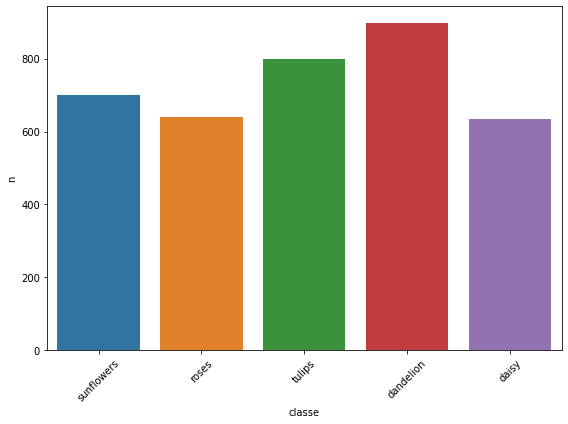

In [ ]:
os.remove("/content/datasets/flower_photos/LICENSE.txt")

dir= "/content/datasets/flower_photos"

dataframe= pd.DataFrame(columns=['classe','n'])

dataframe['classe']=pd.Series([os.listdir(dir)[x] for x in range(0,5)])

dataframe['n']=pd.Series([len(os.listdir(os.path.join(dir,os.listdir(dir)[x]))) for x in range(0,5)])

plt.figure(figsize=(8,6))
g=sns.barplot(x='classe', y='n',data=dataframe)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.tight_layout()

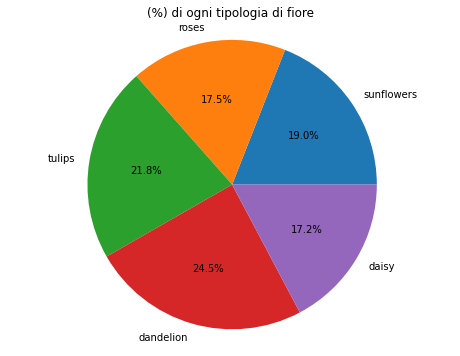

In [ ]:
plt.figure(figsize=(8,6))
plt.tight_layout()
plt.pie(dataframe['n'],
        labels=dataframe['classe'],
        autopct='%1.1f%%')
plt.axis('equal')
plt.title( "(%) di ogni tipologia di fiore")
plt.show()

Il dataset risulta abbastanza bilanciato, poiché il numero di immagini è simile in ogni classe.  

Visualizziamo alcuni esempi di immagini:  

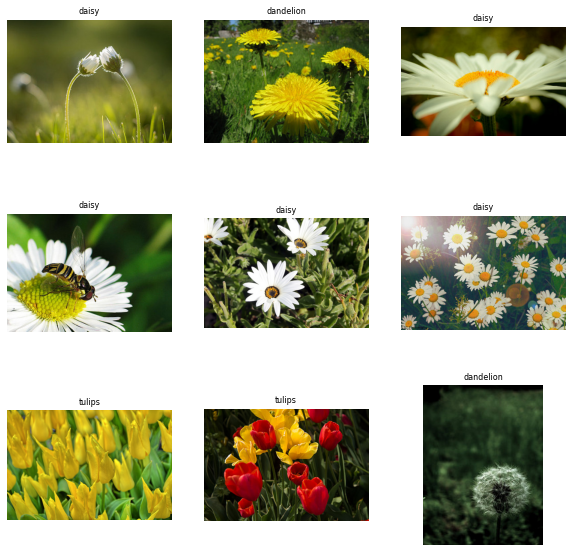

In [ ]:
classes = ["daisy",  "dandelion", "roses", "sunflowers" , "tulips"]

W = 3
H = 3
fig, axes = plt.subplots(W, H, figsize = (10,10))
axes = axes.ravel() 

for i in np.arange(0, 9):
  label = random.choice(classes)
  class_dir = os.path.join(dir,label)    
  image = random.choice(os.listdir(class_dir))
  img = plt.imread(os.path.join(class_dir,image))
  axes[i].imshow( img )
  axes[i].set_title(label, fontsize = 8) 
  axes[i].axis('off')

## Splitting into Training and Validation Sets

Impostiamo inizialmente i parametri principali: 
- Split
- Dimensione delle immagini
- Batch size 
- Shuffle 

Suddividiamo il dataset composto da $3670$ file e $5$ classi in training set e validation set, seguendo la regola $80-20$, ottenendo un training set composto da $2936$ file ed un validation set composto da $734$ file. Per ciò che riguarda la dimensione dell'immagine questo rappresenta un passaggio fondamentale poiché alcuni layer della rete richiedono che vengano passate in input immagini con medesima cardinalità, noi per semplicità scegliamo immagini di dimensioni $224\times224$. Si è ritenuto opportuno scegliere come dimensione del mini batch un valore pari a 32 immagini. Questo parametro è estremamente importante, in particolare un batch troppo elevato rischia di far saltare il processo di addestramento da un punto ad un altro senza considerare dei punti utili per la rete, un batch troppo basso invece comporta tempi maggiori per raggiungere la convergenza, le statistiche saranno poco rappresentative e inoltre se si prevede un Batch normalization questa verrebbe fatta su un numero di immagini troppo basso e quindi poco rappresentative. Quindi si deve scegliere un batch che non sia troppo piccolo da affiggere in modo negativo anche la batch normalization. Impostiamo il tipo di variabile categorica e infine impostiamo `shuffle=True` in modo tale che le immagini vengano prese in modo casuale. Se imponessimo `shuffle = False` è probabile che venga introdotto un bias che deriva dall'ordine con il quale le immagini sono presenti nel file. 
Infine viene definito un `color_mode = "rgb"` poiché prendiamo in considerazione 3 canali per immagine.

In [ ]:
base_path= 'datasets/flower_photos/'
train_dataset = keras.preprocessing.image_dataset_from_directory(base_path,
                                                            image_size=(224,224),
                                                            color_mode='rgb',
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            subset='training',
                                                            validation_split = 0.2,
                                                            shuffle=True,
                                                            seed=1)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_dataset = keras.preprocessing.image_dataset_from_directory(base_path,
                                                            image_size=(224,224),
                                                            color_mode='rgb',
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            subset='validation',
                                                            validation_split = 0.2,
                                                            shuffle=True,
                                                            seed=1)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Prima di procedere, implementiamo un meccanismo di stopping che vada a interrompere l'addestramento se la curva di validation smette di crescere per $20$ epoche consecutive. Abbiamo notato in particolare che valori troppo bassi di patience portavano ad uno stop spesso precoce dell'addestramento non consentendo un adeguato training sui dati. Infatti laddove la rete fornisca una accuracy elevata sin dalle prime epoche l'addestramento si fermerebbe perché l'accuracy delle epoche successive risulta inferiore a quella ottenuta inizialmente. Questo potrebbe essere dovuto al fatto che soprattutto nelle prime fasi di addestramento la quota di stocasticità è superiore, l'addestramento inizia a divenire robusto nelle epoche successive, quindi un modello addestrato solo su poche epoche potrebbe portare a risultati poco soddisfacenti sul test set o su dati nuovi forniti alla rete. 

In [ ]:
num_classes = 5
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 20)

## Training the model

### RETE V1

In questa prima fase definiamo una rete CNN base per cercare di risolvere il problema nella maniera più semplice possibile:
- Costruiamo una rete composta da input layer in cui specifichiamo che le immagini sono di dimensione $224x224$ e con $3$ canali, e $3$ layer convoluzionali in cui avviene la convoluzione che forniscono come output delle features map, che al loro interno contengono:
  - Un layer di attivazione: nello specifico viene applicata la funzione di attivazione ReLu ai nodi interni alla rete per introdurre non linearità. Per valori positivi viene applicata la funzione identità  per valori negativi restituisce valore pari a $0$. 
  - Una funzione di max pooling con `strides = 3`, che viene inserita per ridurre la complessità computazionale, quindi è una sorta di sottocampionamento, in particolare in questo caso si prendono sotto porzioni 3x3 della feature e si mantiene il valore massimo per ogni sotto-porzione in modo tale da ottenere una matrice di dimensioni inferiori permettendo in tal modo di mandare avanti solo le caratteristiche significative. Ogni sotto-porzione viene individuata mandando avanti di tre pixel la finestra. Con strides pari a $3$ si fa riferimento a quanti pixel si sposta la finestra per individuare la nuova sotto-porzione da valutare. La scelta di utilizzare Max pooling e non Avg pooling deriva dal fatto che quest'ultima calcolando delle medie non consentirebbe di identificare e quindi mantenere le feature più nitide e più luminose dell'immagine. L'AVG pooling tende per costruzione a pesare tutte le parti del pooling allo stesso modo ponendo quindi sullo stesso piano sia lo sfondo sia la figura stessa, in tal caso lo sfondo perderebbe il suo potenziale discriminatorio. 
  - Una batch normalization: questo layer viene inserito poiché, la rete viene trainata su batch differenti e si potrebbe avere una eccessiva variazione delle statistiche tra un batch e quello successivo. Questo layer consente di normalizzare l'attivazione di uscita di ciascun layer in ogni sotto-porzione viene individuata mandando avanti di tre pixel la finestra. modo tale che l'output abbia media nulla e varianza unitaria. In questo modo il range di variazione in uscita da ogni neurone viene contenuto.
- Infine concludiamo la struttura della rete con un layer Max pooling globale che prende in considerazione una finestra pool non più $3x3$ come nel caso precedente ma grande quanto l'attivazione che deriva dal layer precedente e con un layer denso con funzione di attivazione soft max, quindi vengono passati input monodimensionali alla rete densa fully connected, l'output di tale processo viene quindi passato alla funzione soft max, che produce per ogni classe una probabilità. 

Per quanto riguarda i Layer convoluzionali si sono scelti filtri $32, 64, 128$ per dare la giusta profondità con dimensioni $3x3$: si è evitato di aumentare ulteriormente qeusta dimensione per evitare di allungare eccessivamente il tempo di computazione, in quanto più si alza ($5x5$ ecc...) più nella procedura di feature selection l'algoritmo diventa pesante perchè deve discriminare scegliendo tra più dati.

L'algoritmo di ottimizzazione utilizzato è RMSprop, una variante dello Stochastic Gradient Descent che permette di evitare variazioni eccessive del gradiente. Nello specifico viene implementato quello che prevede il Mini Batch, perché l'implementazione dell'Rprop che non prevede mini batch risulterebbe  troppo onerosa.

La funzione di costo utilizzata è la Categorical Cross-entropy che viene implementata nel caso di classificazione con più classi. La misura per valutare la bontà del modello è invece l'Accuracy, che rappresenta il numero di immagini classificate correttamente rispetto al totale. 

Infine il numero di epoche è stato settato a $50$. 

In [ ]:
# Architecture definition v1

inputs = keras.Input((224,224,3)) # righe, colonne, canali (nel nostro caso 3 x immagini RGB)

x = inputs


x = keras.layers.Conv2D(32, 3, padding="same")(x)  # 32 filtri di dimensione 3x3; Il padding aggiungere una "cornice" all'immagine in modo che l'immagine venga analizzata per intero durante convoluzione
x = keras.layers.BatchNormalization()(x) # riporta i dati sempre entro un certo range, in modo tale che abbiano una distribuzione con media nulla e varianza unitaria, è una forma di regolarizzazione
x = keras.layers.Activation('relu')(x) # layer che introduce non linearità: il passaggio  tra input e output non avviene per mezzo di una semplice combinazione lineare ma crea un livello di complessità e astrazione maggiore
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #finestre 3x3 e stride pari a 3; ogni 3x3 valori di input vengono sostituiti con il valore max, successivamente si sposta la finestra di 3 pixel a destra.


x = keras.layers.Conv2D(64, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x) # al posto di una finestra 3x3, utilizza una finestra grande quanto  l'intera attivazione del layer precedente

outputs = keras.layers.Dense(num_classes, activation='softmax')(x) #fully connected (in keras dense): 
                                                                   # ha un'attivazione softmax, quest'ultima prende i due numeri  restituiti dal layer dense e li da in input ad una funzione che ha lo scopo di produrre una 
                                                                   # pseudo distribuzione di probabilità (si assicura che la somma dei due valori sia pari a 1).  

net1 = keras.Model(inputs, outputs)

In [ ]:
net1.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
t0 = time()

history = net1.fit(train_dataset,
          epochs=50,
          validation_data=val_dataset);

print("completed in %0.3f seconds" % (time() - t0) )

Epoch 1/50
92/92 [==============================] - 25s 87ms/step - loss: 1.1718 - accuracy: 0.5719 - val_loss: 1.8376 - val_accuracy: 0.4591
Epoch 2/50
92/92 [==============================] - 8s 79ms/step - loss: 0.7928 - accuracy: 0.7061 - val_loss: 0.8288 - val_accuracy: 0.6662
Epoch 3/50
92/92 [==============================] - 8s 80ms/step - loss: 0.6725 - accuracy: 0.7524 - val_loss: 0.6756 - val_accuracy: 0.7466
Epoch 4/50
92/92 [==============================] - 8s 80ms/step - loss: 0.5623 - accuracy: 0.7919 - val_loss: 0.8624 - val_accuracy: 0.6785
Epoch 5/50
92/92 [==============================] - 8s 80ms/step - loss: 0.4859 - accuracy: 0.8212 - val_loss: 0.7835 - val_accuracy: 0.7125
Epoch 6/50
92/92 [==============================] - 8s 80ms/step - loss: 0.4233 - accuracy: 0.8457 - val_loss: 0.9832 - val_accuracy: 0.6376
Epoch 7/50
92/92 [==============================] - 8s 80ms/step - loss: 0.3701 - accuracy: 0.8661 - val_loss: 0.6733 - val_accuracy: 0.7493
Epoch 8/50
9

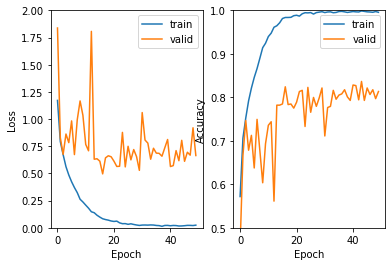

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid']);

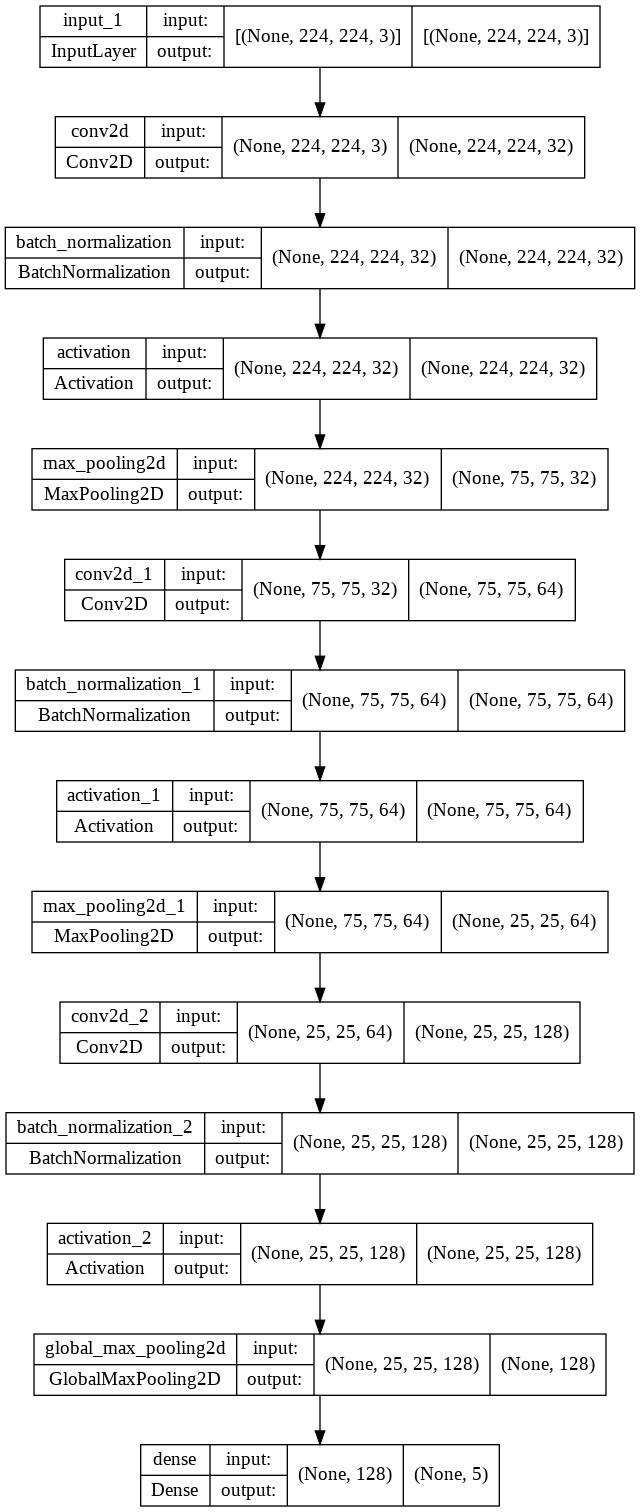

In [ ]:
plot_model(net1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Dai due grafici di perdita e di accuracy si nota la presenza di overfitting, il modello fitta molto bene i dati di training, mentre produce risultati meno soddisfacenti per ciò che riguarda il validation set. Il numero di epoche sembra essere eccessivo in quanto a partire dall'epoca 20 l'addestramento della rete sembra raggiungere il suo massimo e poi a rimanere costante nelle epoche restati, non si notano ulteriori miglioramenti.

### RETE V2 AUGMENTATION

A seguito dei risultati ottenuti, cerchiamo di risolvere il problema di forte overfitting individuato, implementando la tecnica Data Augmentation. Ipotizziamo che l'overfitting possa essere dovuto all'utilizzo di un dataset di dimensioni limitate: la tecnica della Data Augmentation, consente di risolvere parzialmente tale problema mediante alcune operazioni di Flip, Rotation e Zoom casuale sulle immagini, che consentono di aumentare la dimensione del dataset originale andando a creare nuove immagini ruotate, zommate e ribaltate. Questo rappresenta un buon metodo alternativo alla raccolta di nuovi dati e permette di creare un modello più robusto in grado di fornire performance migliori e più accurate grazie ad un training svolto su una maggiore varietà di dati. Nello specifico, per la rotazione e lo zoom viene specificato un valore pari a $0.1$ ciò significa che il valore viene pescato casualmente all'interno del range pari a [-10% 2π , 10% 2π]. Mentre per il ribaltamento si specifica orizzontale, quindi da sinistra verso destra senza alterare i pixel e le dimensioni dell'immagine. 

Nel caso della Random Rotation e RadomZoom impostati a 0.1, la scelta è ricaduta su questo valore in quanto test effettuati con [0.2,...,0.5] avrebbero sì risolto maggiormente il problema dell'overfitting, ma a discapito di una accuracy minore, anche sul validation set.

In [ ]:
# Image Augmentation
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(224, 224,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

In [ ]:
inputs = keras.Input((224,224,3))

x = inputs

x = data_augmentation(x)

x = keras.layers.Conv2D(32, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)


x = keras.layers.Conv2D(64, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x) 

net2 = keras.Model(inputs, outputs)

In [ ]:
net2.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
t0 = time()

history = net2.fit(train_dataset,
          epochs=50,
          validation_data=val_dataset);

print(" completed in %0.3f seconds" % (time() - t0) )

Epoch 1/50
92/92 [==============================] - 10s 83ms/step - loss: 1.2611 - accuracy: 0.5685 - val_loss: 2.3206 - val_accuracy: 0.4087
Epoch 2/50
92/92 [==============================] - 8s 80ms/step - loss: 0.8854 - accuracy: 0.6546 - val_loss: 1.2331 - val_accuracy: 0.5613
Epoch 3/50
92/92 [==============================] - 8s 80ms/step - loss: 0.7870 - accuracy: 0.7013 - val_loss: 0.8786 - val_accuracy: 0.6662
Epoch 4/50
92/92 [==============================] - 8s 80ms/step - loss: 0.7325 - accuracy: 0.7241 - val_loss: 0.9358 - val_accuracy: 0.6553
Epoch 5/50
92/92 [==============================] - 8s 81ms/step - loss: 0.6650 - accuracy: 0.7527 - val_loss: 0.8212 - val_accuracy: 0.7302
Epoch 6/50
92/92 [==============================] - 8s 81ms/step - loss: 0.6540 - accuracy: 0.7510 - val_loss: 0.7364 - val_accuracy: 0.7153
Epoch 7/50
92/92 [==============================] - 8s 81ms/step - loss: 0.6201 - accuracy: 0.7698 - val_loss: 0.6426 - val_accuracy: 0.7616
Epoch 8/50
9

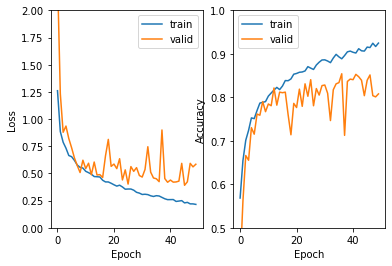

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid']);

L'inserimento della Data Augmentation riduce notevolmente l'overfitting e ci porta ad ottenere risultati soddisfacenti, in particolare si nota una diminuzione del costo che passa da $0.70$ a $0.60$. Ciò che inoltre si nota è una riduzione della distanza tra training set e validation set sia per ciò che riguarda la Loss, sia per ciò che riguarda l'Accuracy.

### RETE V3 NORMALIZZAZIONE E LR DECAY

I risultanti ottenuti nella V2 della nostra rete sono soddisfacenti e in questa V3 cercheremo di ottimizzare ulteriormente la rete utilizzando come algoritmo di ottimizzazione lo Stachastic Gradient Descent, nello specifico:
- Sulla base del principio "Garbage In, garbage Out" applicheremo una Grey Scale Normalization ai dati prima di inserirli nella rete. Questo tipo  di normalizzazione consente di cambiare il range dei valori di intensità dei pixel riducendo i valori dei pixel in un range definito tra 0 e 1. Strumento particolarmente interessante per generalizzare tra le immagini con contrasti di luce molto differenti (foto scattate in orari molto diversi). Inoltre dovrebbe consentire alla rete di convergere più velocemente.

- Imposteremo il learning rate secondo il principio del LR decay, cioè a partire da un valore fissato $0.1$ il learning rate scenderà ad ogni epoca di addestramento finché non raggiunge un minimo locale. Tale tecnica viene utilizzata per migliorare le performance del modello sia in termini di accuratezza sia in termini di capacità di generalizzare. Quest'ultima in particolare rappresenta la capacità del modello di classificare correttamente immagini mai viste che presentano una distribuzione simile a quella dei dati di training e pertanto riuscire a trasferire le conoscenze apprese sui nuovi dati. 

In particolare il momentum consente di rimanere in traiettoria durante le fasi di update, evitando di rimanere incastrati in ottimi locali, il learning rate consente di evitare oscillazioni troppo ampie durante la fase di training e di evitare minimi locali spuri, in particolare fissare un learning rate alto iniziale consentirebbe di evitare il rumore iniziale e di migliorare il training sui dati. 

In [ ]:
epochs=50

learning_rate = 0.1

decay_rate = learning_rate / epochs

momentum = 0.8

sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [ ]:
def norm(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_dataset = train_dataset.map(norm)
val_dataset = val_dataset.map(norm)

In [ ]:
inputs = keras.Input((224,224,3))

x = inputs

x = data_augmentation(x)

x = keras.layers.Conv2D(32, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)


x = keras.layers.Conv2D(64, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x) 

net3 = keras.Model(inputs, outputs)

In [ ]:
net3.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=sgd,
            metrics=['accuracy'])

In [ ]:
t0 = time()

history = net3.fit(train_dataset,
          epochs=50,
          validation_data=val_dataset,
          callbacks=[callback]);

print(" completed in %0.3f seconds" % (time() - t0) )

Epoch 1/50
92/92 [==============================] - 11s 99ms/step - loss: 2.6069 - accuracy: 0.4029 - val_loss: 1.8103 - val_accuracy: 0.3338
Epoch 2/50
92/92 [==============================] - 8s 83ms/step - loss: 1.0958 - accuracy: 0.5525 - val_loss: 1.1667 - val_accuracy: 0.5300
Epoch 3/50
92/92 [==============================] - 8s 85ms/step - loss: 1.0189 - accuracy: 0.5858 - val_loss: 1.0277 - val_accuracy: 0.5954
Epoch 4/50
92/92 [==============================] - 8s 84ms/step - loss: 0.9918 - accuracy: 0.6121 - val_loss: 0.9302 - val_accuracy: 0.6063
Epoch 5/50
92/92 [==============================] - 8s 84ms/step - loss: 0.9339 - accuracy: 0.6311 - val_loss: 0.8808 - val_accuracy: 0.6703
Epoch 6/50
92/92 [==============================] - 8s 84ms/step - loss: 0.8800 - accuracy: 0.6553 - val_loss: 0.8314 - val_accuracy: 0.6907
Epoch 7/50
92/92 [==============================] - 8s 84ms/step - loss: 0.8768 - accuracy: 0.6526 - val_loss: 0.8687 - val_accuracy: 0.6553
Epoch 8/50
9

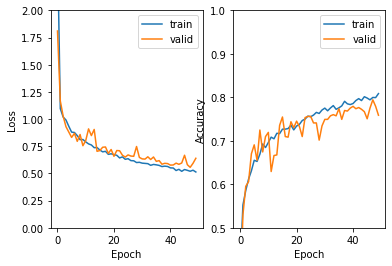

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid']);

La nuova rete elimina quasi interamente l'overfitting e riduce drasticamente la variabilità del risultato ottenuto ad ogni epoca di addestramento.
Quello che inoltre si può notare è che all'epoca $50$ vi è una tendenza dell'accuracy a crescere e della Loss a diminuire, pertanto si può ipotizzare di introdurre ulteriori epoche per migliorare l'addestramento. Date tali premesse si può affermare che l'addestramento risulta adesso più costoso, poiché a parità di epoche rispetto alle reti precedenti si ottiene una accuracy inferiore e una Loss superiore.  

### RETE V4

In quest'ultima architettura, viene mantenuta la struttura precedentemente implementata che prevede quindi lo Stochastic Gradient Descent, la normalizzazione di dati, Data Augmentation, learning rate Decay a cui andremo ad aggiungere la regolarizzazione dei parametri. 

La regolarizzazione serve a contenete l'ordine di grandezza dei pesi dei layer: 
- Per scelta si andrà ad applicare ai layer convoluzionali e al layer Dense
- Non si andranno ad applicare regolarizzatori alle attivazioni perchè su di esse svolge già un lavoro simile la Batch Normalization, per cui non riteniamo utile aumentare il livello di complessità della rete su di esse. 

Nello specifico, utilizzando un L2, applichiamo una Ridge Regression che è un tecnica che si basa sul decadimento dei pesi: questa regolarizzazione "guida" i pesi verso il punto di origine, "controllando" quindi che non varino troppo.

In [ ]:
inputs = keras.Input((224,224,3))

x = inputs

x = data_augmentation(x)

x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
net4 = keras.Model(inputs, outputs)

In [ ]:
net4.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=sgd,
            metrics=['accuracy'])

In [ ]:
t0 = time()

history = net4.fit(train_dataset,
          epochs=50,
          validation_data=val_dataset,
          callbacks=[callback]);

print(" completed in %0.3f seconds" % (time() - t0) )

Epoch 1/50
92/92 [==============================] - 9s 86ms/step - loss: 1.5469 - accuracy: 0.5102 - val_loss: 1.5132 - val_accuracy: 0.4087
Epoch 2/50
92/92 [==============================] - 8s 84ms/step - loss: 1.1838 - accuracy: 0.6076 - val_loss: 1.6173 - val_accuracy: 0.4428
Epoch 3/50
92/92 [==============================] - 8s 84ms/step - loss: 1.0725 - accuracy: 0.6505 - val_loss: 1.2193 - val_accuracy: 0.5613
Epoch 4/50
92/92 [==============================] - 8s 85ms/step - loss: 0.9551 - accuracy: 0.6914 - val_loss: 0.9272 - val_accuracy: 0.7248
Epoch 5/50
92/92 [==============================] - 8s 85ms/step - loss: 0.9477 - accuracy: 0.6945 - val_loss: 0.9078 - val_accuracy: 0.7030
Epoch 6/50
92/92 [==============================] - 8s 85ms/step - loss: 0.8915 - accuracy: 0.7193 - val_loss: 1.0665 - val_accuracy: 0.6689
Epoch 7/50
92/92 [==============================] - 8s 84ms/step - loss: 0.8797 - accuracy: 0.7197 - val_loss: 0.8053 - val_accuracy: 0.7548
Epoch 8/50
92

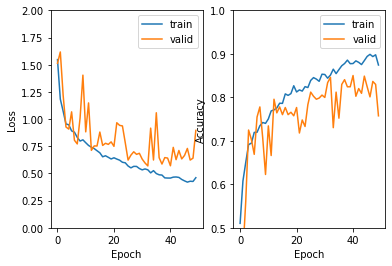

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

Rispetto alla rete precedente si nota un aumento di accuratezza e una Loss superiore, in particolare in questo caso si nota una varianza più elevata per il validation set sia nell'accuracy che nella Loss. Rispetto alla seconda rete, si nota un leggero trade of tra accuracy e overfitting. Un aumento delle epoche potrebbe forse portare ad un ulteriore miglioramento delle performance in termini di Accuracy e Loss, rischiando però di aumentare nuovamente l'overfitting della rete.

In [ ]:
report4 = classification_report(labels, predictions, target_names = classes, digits = 2, output_dict=True)

display.display(pd.DataFrame(report4))
df = pd.DataFrame(report4)
df.iloc[:3, :5].T.plot(kind='bar')
plt.show()

##  Confusion Matrix on the Validation Set

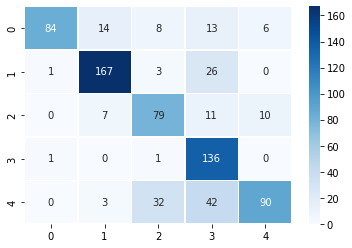

In [ ]:
predictions = np.array([])
labels =  np.array([])

for x, y in val_dataset:

  predictions = np.concatenate([predictions, np.argmax(net4.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

sns.heatmap(confusion_matrix(labels, predictions), annot=True, fmt = '.0f',linewidths=.5,  cmap='Blues');


Dalla matrice di confusione si nota come ci sia una discreta classificazione delle immagini per ogni specie di fiore